In [2]:
# modules
from tools.trendAnalysis import timeSeriesStack,trendArray
import numpy as np
import pandas as pd
from tools.old.HTfunctions import readRunoff
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
dataDIR = "/Users/skam2905/Documents/UP WHK/HydroTrends/Data"

metadataFull = pd.read_csv(Path(dataDIR).joinpath("updated_stationselection.csv"),index_col=0)

stationList = [2000011,2200022,2800007]

metadata = metadataFull[metadataFull["snumber"].isin(stationList)]
metadata = metadataFull[metadataFull["start.yr"]<1900]

In [4]:
metadata

,snumber,regine,main,name,stnr,start.yr,end.yr,missing.yr,areal,altitude,utm.e,runoff.region,lon,lat,BREPRO,station.order,seNorge,missingData30yr
42,6200005,62,5,Bulken (Vangsvatnet),62.500,1892,2014,0,1092.04,867.0,24487.79,vestlandet,6.291809,60.629297,0.39,27,1,0.0
13,200145,2,145,BaattstO,2.145,1896,2012,0,11212.84,1139.0,247417.27,ostlandet,10.277532,61.333385,3.00,41,1,0.0
34,200604,2,604,Elverum,2.604,1871,2013,0,15451.76,817.0,313303.90,ostlandet,11.560652,60.874212,0.00,20,1,0.0
36,31100004,311,4,Femundsenden (Femunden),311.400,1896,2013,0,1794.03,782.0,339350.00,ostlandet,11.940043,61.919961,0.00,18,1,0.0
9,2200004,22,4,KjOlemo,22.400,1896,2013,0,1757.70,560.0,60352.10,sorlandet,7.527672,58.120237,0.00,16,1,0.0
17,2000003,20,3,Flaksvatn,20.300,1899,2013,0,1780.66,354.0,102366.62,sorlandet,8.203061,58.330464,0.00,8,1,0.0


In [5]:
metadata.sort_values("altitude")
list(metadata["altitude"])
ids = list(metadata["snumber"])

In [6]:
data = {}
for c in ids:
    data[c] = readRunoff(c,folder=Path(dataDIR).joinpath("runoff"))

In [7]:
ts = timeSeriesStack(data=data,
                    variable="streamflow",
                    unit="m3/s",
                    metadata=metadata,
                    sortBy="altitude",
                    IDcol="snumber",
                    MA=10,
                    startYear=1901,
                    endYear=2000)

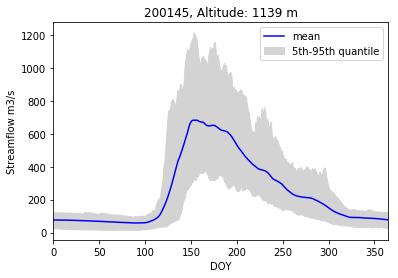

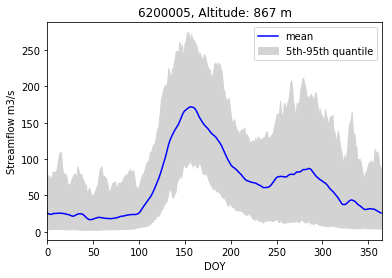

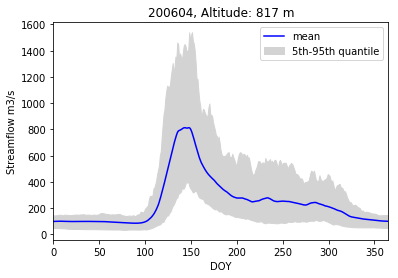

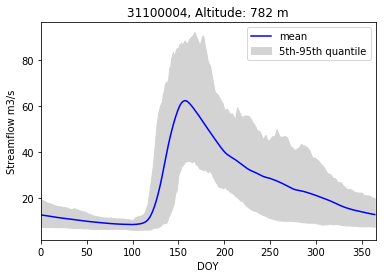

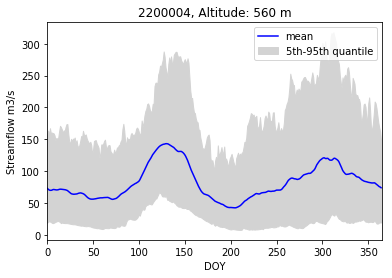

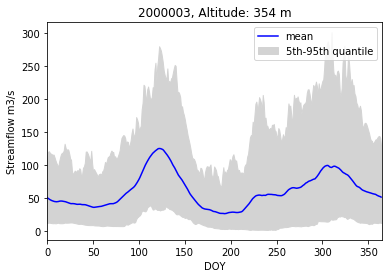

In [8]:
ts.quickplot()

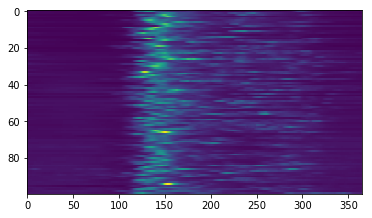

In [14]:
plt.imshow(ts.array[:,:,2].T,aspect=2)

In [10]:
ta = trendArray(ts)
ta.mag(method="theil-sen",change="rel")
ta.sign("mann-kendall")

In [11]:
name="testing"
ts.saveToFile(name)
ta.saveToFile(name)

([<matplotlib.axis.YTick at 0x7f9f092f58d0>,
 <a list of 6 Text yticklabel objects>)

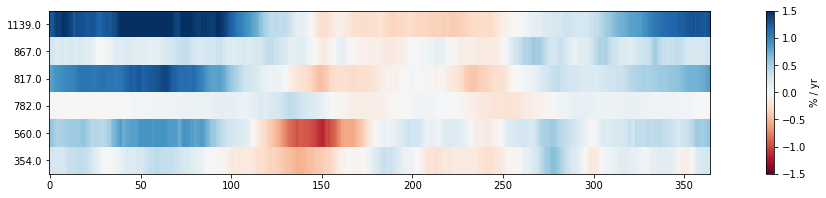

In [12]:
plt.figure(figsize=(20,3))
plt.imshow(ta.magnitudes,vmin=-1.5,vmax=1.5,aspect=15,cmap="RdBu")
plt.colorbar(label=ta.trendUnit)
plt.yticks(range(len(ta.IDs)),ta.tsStack.sortAttributeValues)

In [64]:
round(np.mean(np.quantile(ta.magnitudes*factor,0.95,axis=1)))

8

(6, 0)

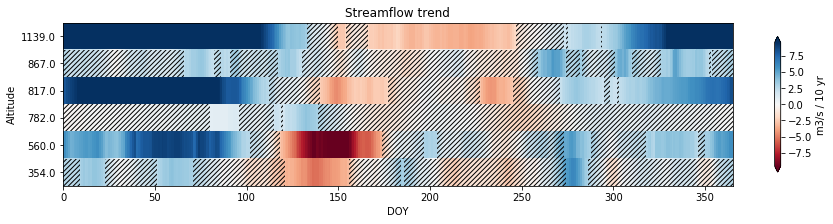

In [70]:
factor=10
cmap = "RdBu"

# magnitudes
arr = ta.magnitudes*factor
extent = max([np.abs(np.nanmax(arr,axis=1).mean()),np.abs(np.nanmin(arr,axis=1).mean())])
extent = np.quantile(ta.magnitudes*factor,0.9)

# plot
plt.figure(figsize=(15,arr.shape[0]/2))
plt.pcolormesh(arr,vmin=-extent,vmax=extent,cmap=cmap)

# colorbar
unit = f"{ta.tsStack.unit} / {factor} yr"
plt.colorbar(shrink=5/arr.shape[0],extend="both",label=unit)

# annual
#ann = (np.array([data[region][var]["annual"],]*8).T)*factor
#x = np.arange(arr.shape[1]+1,arr.shape[1]+ann.shape[1]+1)
#y = np.arange(arr.shape[0]+1)
#cmapAnn = plt.cm.get_cmap("binary")
#cmapAnn.set_under("magenta")
#cmapAnn.set_over("lime")
#plt.pcolormesh(x,y,ann,vmin=-1/10**5,vmax=1/10**5,cmap=cmapAnn)

# significance
sig = ta.significance

mask = np.ma.masked_array(np.full_like(sig,-9999),sig == 1)
#plt.imshow(mask,**sigArgs)
#plt.contourf(mask, 1, hatches=['//////'], colors="grey", alpha=0.1)
plt.pcolor(mask, hatch='/////', alpha=0.,snap=True,label="Non-significant")

# field significance
#plt.hlines(-0.1,0,365,colors="k",linewidth=0.5)
#field = data[region][var]["FieldSig"]
#x = np.arange(365).astype(float)
#y = np.full_like(x,-0.5)
#np.place(x,field==False,np.nan)
#np.place(y,field==False,np.nan)
#plt.plot(x,y,"-",color="orange",linewidth=4)

# labels etc
plt.title(f"{ta.tsStack.variable.capitalize()} trend")
plt.xlabel("DOY")
plt.ylabel(ta.tsStack.sortedBy.capitalize())
ticks = np.arange(0,arr.shape[0],1)
plt.yticks(ticks+0.5,np.array(ta.tsStack.sortAttributeValues))
plt.ylim(arr.shape[0],0)
#plt.xlim(0,arr.shape[1]+0.5)

# save figure
#name = data[region][var]['name']
#plt.savefig(f"Plots/{period}/dailyTrend_{name}.png",dpi=500,bbox_inches="tight")